In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import rbf_kernel

from quantileKernelMixCp.qKM import qKMPredict, qKM
from quantileKernelMixCp.generate_qkm import *
from quantileKernelMixCp.utils import *

## Generate data 
- true topic proportions $W$ are known
- Kernel: Gaussian kernel on distance of $[clr(W),X_0]$
- $f(x) = \beta_0 + W_{1:K}^{\top}\beta_1 + \frac{1}{\lambda}K(x)\theta$


In [2]:
N = 1000 # document length
n = 1000 # number of samples
p = 50 # X1 dimension (number of words)
p0 = 3 # X0 dimension (number of non-topic related covariates)
K = 3 # W dimenstion (number of topics)
covariate_W = True # do we know true topic proportion

alpha = 0.1 # 1-coverage
gamma = 1 # scale parameter in Gaussian kernel

# other parameters
threshold = 1-alpha
max_steps = 200
eps1 = 1e-04
eps2 = 1e-02

np.random.seed(111)
sim_data = generate_qkm(N, n, p, p0, K)
Xcalib, Xtest, Ycalib, Ytest = sim_data['Xcalib_clr'], sim_data['Xtest_clr'], sim_data['Ycalib'], sim_data['Ytest']
scoresCalib, scoresTest = sim_data['scoresCalib'], sim_data['scoresTest']
phiCalib, phiTest = sim_data['phiCalib'], sim_data['phiTest']

## Method 1: Quantile Kernel regression using solution path

### A. Calculate coverage

In [3]:
# QKM
covers = []
lambdas = []
thetas = []

i = 0
for x_val, y_val in zip(Xtest, scoresTest):
    x_val = x_val.reshape(1,-1)
    X = np.vstack([Xcalib, x_val])
    y = np.append(scoresCalib, y_val)
    PhiX = np.vstack([phiCalib, phiTest[i].reshape(1,-1)])
    res = qKM(X, y.ravel(), 1-alpha, PhiX, max_steps, gamma, eps1, eps2)
    opt = np.argmin(res['Csic'])
    lambd_opt = res['lambda'][opt]
    lambdas.append(lambd_opt)
    f = res['fit'][opt][-1]
    covers.append(y_val <= f)
    i+=1


### B. Calculate prediction set size

In [4]:
cutoffs_qkm = []
i = 0
for x_val, y_val in zip(Xtest, phiTest):
    Smin, Smax, lambdas = qKMPredict(Xcalib, scoresCalib, threshold, 
                            phiCalib, x_val, y_val,
                            max_steps,
                            min(scoresCalib), # initial binary search space (lower)
                            1) # initial binary search space (upper)
    cutoffs_qkm.append(Smin)
    i+=1

## Method 2: Split CP

In [5]:
nCalib = len(scoresCalib)
cutoff_scp = np.quantile(scoresCalib, [(1-alpha) * (1 + 1/nCalib)])
covers_scp = scoresTest <= cutoff_scp
cutoff_scp = [cutoff_scp[0]]*100

## Plot

In [6]:
test_idx = sim_data['test_idx']
W = sim_data['W']
Wtest = W[test_idx]

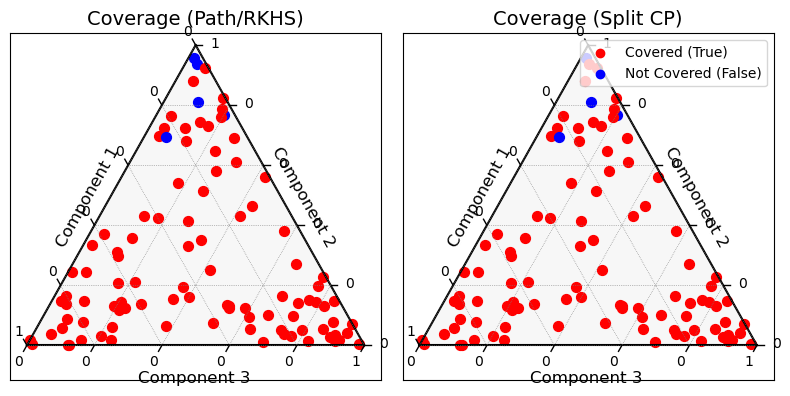

Coverage for our method: 0.95, Coverage for SplitCP: 0.96


/var/folders/0b/w1czghy14lgbrx9zm77dkkvw0000gn/T/ipykernel_62375/2332993860.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


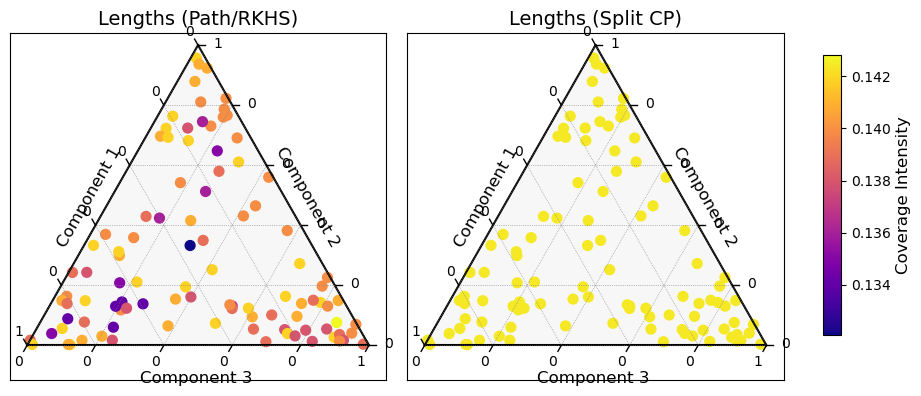

In [10]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

data_points = [tuple(row) for row in Wtest[:,:K]]
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
plot_ternary(data_points, covers, "Coverage (Path/RKHS)", axs[0])
plot_ternary(data_points, covers_scp, "Coverage (Split CP)", axs[1])
plt.scatter([], [], color='red', label="Covered (True)")
plt.scatter([], [], color='blue', label="Not Covered (False)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
print(f"Coverage for our method: {np.mean(covers)}, Coverage for SplitCP: {np.mean(covers_scp)}")

cmap = cm.plasma
vmin = np.min(cutoffs_qkm)
vmax = np.max(cutoffs_qkm)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
scatter1 = plot_ternary_size(data_points, cutoffs_qkm, "Lengths (Path/RKHS)", axs[0], vmin, vmax)
scatter2 = plot_ternary_size(data_points, cutoff_scp, "Lengths (Split CP)", axs[1], vmin, vmax)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label("Coverage Intensity", fontsize=12)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()